# Handling FITS Files 

* [Format definition of HEALPIX headers in FITS for Maps](https://gamma-astro-data-formats.readthedocs.io/en/latest/skymaps/healpix/index.html#healpix-skymap)
* https://docs.gammapy.org/dev/_modules/gammapy/maps/hpx.html
* https://clumpy.gitlab.io/CLUMPY/quick_start.html#displaying-a-2d-run-with-python


## Setup

In [1]:
from astropy.io import fits
from astropy.table import Table
from gammapy.maps import Map
from matplotlib import pyplot as plt
import healpy as hp
import numpy as np
%matplotlib notebook

## Open FITS

In [2]:
clumpyfits = '../datasets/annihil_Perseus_A4262D_FOVdiameter2.0deg_nside1024.fits'
hdulist = fits.open(clumpyfits)
hdulist.info()

Filename: ../datasets/annihil_Perseus_A4262D_FOVdiameter2.0deg_nside1024.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       7   ()      
  1  JFACTOR       1 BinTableHDU    144   960R x 6C   [1J, 1E, 1E, 1E, 1E, 1E]   
  2  JFACTOR_PER_SR    1 BinTableHDU    144   960R x 6C   [1J, 1E, 1E, 1E, 1E, 1E]   
  3  INTEGRATED_FLUXES    1 BinTableHDU    172   960R x 5C   [1J, 1E, 1E, 1E, 1E]   


**Select HDU 3 and insoect headers**

In [3]:
hdu = hdulist[3]
#hdu.header      #print header of HDU 3

## Check existence of header keywords

Check if header keywords from [Format definition of HEALPIX headers in FITS for Maps](https://gamma-astro-data-formats.readthedocs.io/en/latest/skymaps/healpix/index.html#healpix-skymap) are present

In [4]:
keywds = (
    'HPX_CONV',
    'PIXTYPE',
    'INDXSCHM',
    'ORDERING',
    'COORDSYS',
    'ORDER',
    'NSIDE',
    'FIRSTPIX',
    'LASTPIX',
    'HPX_REG',
    'BANDSHDU',
)
          
_ = [print(kw, '=', hdu.header[kw]) for kw in keywds if kw in hdu.header]
_ = [print(kw) for kw in keywds if kw not in hdu.header]

PIXTYPE = HEALPIX
INDXSCHM = EXPLICIT
ORDERING = NESTED
COORDSYS = G
NSIDE = 1024
HPX_CONV
ORDER
FIRSTPIX
LASTPIX
HPX_REG
BANDSHDU


In [5]:
print(hdu.header['TTYPE1'], hdu.header['TTYPE2'])

PIXEL Flux_gamma


## Modify FITS

Let's change some headers to trick [Gammapy code to load healpix images](https://docs.gammapy.org/dev/_modules/gammapy/maps/hpx.html) and write a modified FITS

In [6]:
hdu.header['HPX_CONV'] = 'FGST-SRCMAP'
hdu.header['TTYPE1'] = 'PIX'
hdu.header['COORDSYS'] = 'GAL'
#hdu.header['TTYPE2'] = 'CHANNEL0'
#hdu.header
#
hdu.writeto('../datasets/annihil_modified.fits', overwrite=True)
hdulist.close()  # close when finished to work with info from opened file

In [7]:
clumpyfits = '../datasets/annihil_modified.fits'
#clumpyfits = '../datasets/annihil_Perseus_A4262D_FOVdiameter2.0deg_nside1024.fits'

## Load FITS with Gammapy Maps

Let's try loading the modified FITS file with Gammapy Map

(<Figure size 432x288 with 1 Axes>,
 None)

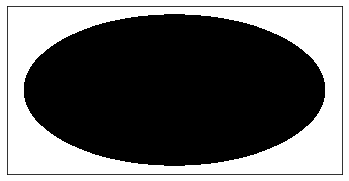

In [8]:
map_dm = Map.read(clumpyfits)
map_dm.plot(vmin=3.34e-18, vmax=5e-17)

In [9]:
print(map_dm.geom)

HpxGeom

	axes       : ['skycoord']
	shape      : (12582912,)
	ndim       : 2
	nside      : 1024
	nested     : True
	coordsys   : GAL
	projection : HPX
	center     : 0.0 deg, 0.0 deg



In [10]:
map_dm.data.sum()
#map_dm.data.shape

0.0

**No values have been loaded, it is an empty Map**

## Load values from original FITS file with Healpy

In [11]:
clumpyfits = '../datasets/annihil_Perseus_A4262D_FOVdiameter2.0deg_nside1024.fits'

In [12]:
ext = 3 # fluxes and intensities
col = 1 # gamma-ray intensity
data = hp.read_map(clumpyfits, partial=True, hdu=ext, field=col-1)

NSIDE = 1024
ORDERING = NESTED in fits file
INDXSCHM = EXPLICIT
Ordering converted to RING


In [13]:
hdulist = fits.open(clumpyfits)
hdulist.info()
hdulist.close()

Filename: ../datasets/annihil_Perseus_A4262D_FOVdiameter2.0deg_nside1024.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       7   ()      
  1  JFACTOR       1 BinTableHDU    144   960R x 6C   [1J, 1E, 1E, 1E, 1E, 1E]   
  2  JFACTOR_PER_SR    1 BinTableHDU    144   960R x 6C   [1J, 1E, 1E, 1E, 1E, 1E]   
  3  INTEGRATED_FLUXES    1 BinTableHDU    172   960R x 5C   [1J, 1E, 1E, 1E, 1E]   


In [14]:
len(data)  # The 960 pixels are stored in a 12582912 length array => NSIDE x NSIDE x 12

12582912

## Display original FITS file with Healpy

/Users/jer/anaconda/envs/gammapy-dev/lib/python3.7/site-packages/healpy/projaxes.py:1133: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/Users/jer/anaconda/envs/gammapy-dev/lib/python3.7/site-packages/healpy/projaxes.py:1091: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):


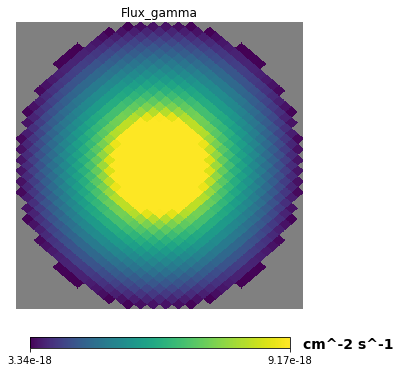

In [15]:
#astropy fits to fetch info from headers
hdulist = fits.open(clumpyfits)
dtheta = hdulist[ext].header['SIZE_Y']
dtheta_orth = hdulist[ext].header['SIZE_X']
title = hdulist[ext].header['TTYPE'+str(col+1)]
units = hdulist[ext].header['TUNIT'+str(col+1)]
hdulist.close()

#healpy cartview to display the spatial template
opts = {
    'lonra': [-dtheta_orth/2,dtheta_orth/2],
    'latra': [-dtheta/2,dtheta/2], 
    'norm': 'log', 
    'max': data.max()/50,
    'title':title,
    'unit': units,
}
hp.cartview(data, **opts)

## Inspect values loaded with Healpy 

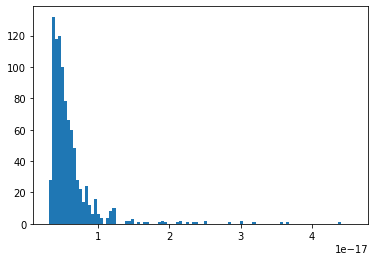

In [16]:
plt.hist(data, bins=100, range=(3e-18, 4.58e-17));

In [17]:
data[data>0].shape

(960,)

In [18]:
good_data = data[data>0]
# good_data   # print good_data

## Try to create a Gammapy Map from values loaded

We will take the first 900 values from ``good_data`` (it actually contains 960) because we want a spatially squared Map.

Let's say we want to build a 30pix x 30pix Map with a 2 deg width in GAL reference frame.

In [19]:
m_dark = Map.create(
    binsz=2/30, width=2, coordsys="GAL")

In [20]:
good_data = good_data[:900]

In [21]:
m_dark.data = good_data.reshape(30, 30)

(<Figure size 432x288 with 1 Axes>,
 None)

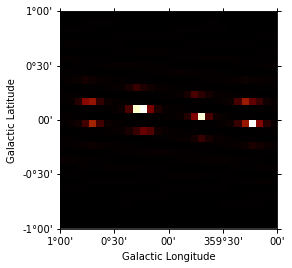

In [22]:
m_dark.plot()

**Oups !!!**
Obviously, spatial info is not well encoded :)

## Tabular FITS

In [23]:
fitsfile = '../datasets/hdu-index.fits.gz'
hdulist = fits.open(fitsfile)
hdulist.info()

Filename: ../datasets/hdu-index.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     22   10026R x 6C   [K, 6A, 10A, 42A, 23A, 21A]   


In [24]:
hdu = hdulist[1]
hdu.header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  110 / length of dimension 1                          
NAXIS2  =                10026 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    6 / number of table fields                         
TTYPE1  = 'OBS_ID  '                                                            
TFORM1  = 'K       '                                                            
TTYPE2  = 'HDU_TYPE'                                                            
TFORM2  = '6A      '                                                            
TTYPE3  = 'HDU_CLASS'       

In [25]:
hdu.columns

ColDefs(
    name = 'OBS_ID'; format = 'K'
    name = 'HDU_TYPE'; format = '6A'
    name = 'HDU_CLASS'; format = '10A'
    name = 'FILE_DIR'; format = '42A'
    name = 'FILE_NAME'; format = '23A'
    name = 'HDU_NAME'; format = '21A'
)

In [26]:
hdu.data

FITS_rec([(310000, 'events', 'events', '../../data/baseline/gc', 'gc_baseline_310000.fits', 'EVENTS'),
          (310000, 'gti', 'gti', '../../data/baseline/gc', 'gc_baseline_310000.fits', 'GTI'),
          (310000, 'aeff', 'aeff_2d', '../../caldb/data/cta/1dc/bcf/South_z20_50h', 'irf_file.fits', 'EFFECTIVE AREA'),
          ...,
          (311670, 'edisp', 'edisp_2d', '../../caldb/data/cta/1dc/bcf/South_z20_50h', 'irf_file.fits', 'ENERGY DISPERSION'),
          (311670, 'psf', 'psf_3gauss', '../../caldb/data/cta/1dc/bcf/South_z20_50h', 'irf_file.fits', 'POINT SPREAD FUNCTION'),
          (311670, 'bkg', 'bkg_3d', '../../caldb/data/cta/1dc/bcf/South_z20_50h', 'irf_file.fits', 'BACKGROUND')],
         dtype=(numpy.record, [('OBS_ID', '>i8'), ('HDU_TYPE', 'S6'), ('HDU_CLASS', 'S10'), ('FILE_DIR', 'S42'), ('FILE_NAME', 'S23'), ('HDU_NAME', 'S21')]))

In [27]:
hdulist.close()

## Tabular FITS with Astropy Table

In [28]:
table = Table.read(fitsfile)
table.info()

<Table length=10026>
   name    dtype 
--------- -------
   OBS_ID   int64
 HDU_TYPE  bytes6
HDU_CLASS bytes10
 FILE_DIR bytes42
FILE_NAME bytes23
 HDU_NAME bytes21


In [29]:
table.info("stats")

<Table length=10026>
   name     mean          std          min    max  
--------- -------- ------------------ ------ ------
   OBS_ID 310835.0 482.37606352996687 310000 311670
 HDU_TYPE       --                 --     --     --
HDU_CLASS       --                 --     --     --
 FILE_DIR       --                 --     --     --
FILE_NAME       --                 --     --     --
 HDU_NAME       --                 --     --     --


In [30]:
table

OBS_ID,HDU_TYPE,HDU_CLASS,FILE_DIR,FILE_NAME,HDU_NAME
int64,bytes6,bytes10,bytes42,bytes23,bytes21
310000,events,events,../../data/baseline/gc,gc_baseline_310000.fits,EVENTS
310000,gti,gti,../../data/baseline/gc,gc_baseline_310000.fits,GTI
310000,aeff,aeff_2d,../../caldb/data/cta/1dc/bcf/South_z20_50h,irf_file.fits,EFFECTIVE AREA
310000,edisp,edisp_2d,../../caldb/data/cta/1dc/bcf/South_z20_50h,irf_file.fits,ENERGY DISPERSION
310000,psf,psf_3gauss,../../caldb/data/cta/1dc/bcf/South_z20_50h,irf_file.fits,POINT SPREAD FUNCTION
310000,bkg,bkg_3d,../../caldb/data/cta/1dc/bcf/South_z20_50h,irf_file.fits,BACKGROUND
310001,events,events,../../data/baseline/gc,gc_baseline_310001.fits,EVENTS
310001,gti,gti,../../data/baseline/gc,gc_baseline_310001.fits,GTI
310001,aeff,aeff_2d,../../caldb/data/cta/1dc/bcf/South_z20_50h,irf_file.fits,EFFECTIVE AREA


In [31]:
table.show_in_notebook()

idx,OBS_ID,HDU_TYPE,HDU_CLASS,FILE_DIR,FILE_NAME,HDU_NAME
0,310000,events,events,../../data/baseline/gc,gc_baseline_310000.fits,EVENTS
1,310000,gti,gti,../../data/baseline/gc,gc_baseline_310000.fits,GTI
2,310000,aeff,aeff_2d,../../caldb/data/cta/1dc/bcf/South_z20_50h,irf_file.fits,EFFECTIVE AREA
3,310000,edisp,edisp_2d,../../caldb/data/cta/1dc/bcf/South_z20_50h,irf_file.fits,ENERGY DISPERSION
4,310000,psf,psf_3gauss,../../caldb/data/cta/1dc/bcf/South_z20_50h,irf_file.fits,POINT SPREAD FUNCTION
5,310000,bkg,bkg_3d,../../caldb/data/cta/1dc/bcf/South_z20_50h,irf_file.fits,BACKGROUND
6,310001,events,events,../../data/baseline/gc,gc_baseline_310001.fits,EVENTS
7,310001,gti,gti,../../data/baseline/gc,gc_baseline_310001.fits,GTI
8,310001,aeff,aeff_2d,../../caldb/data/cta/1dc/bcf/South_z20_50h,irf_file.fits,EFFECTIVE AREA
9,310001,edisp,edisp_2d,../../caldb/data/cta/1dc/bcf/South_z20_50h,irf_file.fits,ENERGY DISPERSION


In [32]:
table.show_in_browser()